In [1]:
try:
    import mlagents
    from mlagents_envs.environment import UnityEnvironment as UE
    from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel
    print("ml-agents already installed")
except ImportError:
    !pip install mlagents==0.26.0
    print("Installed ml-agents")

ml-agents already installed


In [122]:
import torch
from typing import Tuple
from math import floor


class VisualQNetwork(torch.nn.Module):
  def __init__(
    self,
    input_shape: Tuple[int], 
    encoding_size: int, 
    output_size: int
  ):
    """
    Creates a neural network that takes as input a batch of images (3
    dimensional tensors) and outputs a batch of outputs (1 dimensional
    tensors)
    """
    super(VisualQNetwork, self).__init__()
#     height = input_shape[0]
#     width = input_shape[1]
#     initial_channels = input_shape[2]
#     conv_1_hw = self.conv_output_shape((height, width), 8, 4)
#     conv_2_hw = self.conv_output_shape(conv_1_hw, 4, 2)
#     self.final_flat = conv_2_hw[0] * conv_2_hw[1] * 32
    
    
#     self.conv1 = torch.nn.Conv2d(initial_channels, 16, [8, 8], [4, 4])
#     self.conv2 = torch.nn.Conv2d(16, 32, [4, 4], [2, 2])
#     self.dense1 = torch.nn.Linear(self.final_flat, encoding_size)

    
    self.dense1 = torch.nn.Linear(input_shape[0], encoding_size)
    
    self.dense2_x1 = torch.nn.Linear(encoding_size, output_size)
    self.dense2_x2 = torch.nn.Linear(encoding_size, output_size)
    self.dense2_x3 = torch.nn.Linear(encoding_size, output_size)

    
    
  def forward(self, visual_obs: torch.tensor):
#     print("torch input size:", visual_obs.size())
#     visual_obs = visual_obs.permute(0, 3, 1, 2)
#     conv_1 = torch.relu(self.conv1(visual_obs))
#     conv_2 = torch.relu(self.conv2(conv_1))
#     hidden = self.dense1(conv_2.reshape([-1, self.final_flat]))

    hidden = self.dense1(visual_obs)
    hidden = torch.relu(hidden)
    
    x1 = self.dense2_x1(hidden)
    x2 = self.dense2_x2(hidden)
    x3 = self.dense2_x3(hidden)

    return x1, x2, x3

  @staticmethod
  def conv_output_shape(
    h_w: Tuple[int, int],
    kernel_size: int = 1,
    stride: int = 1,
    pad: int = 0,
    dilation: int = 1,
  ):
    """
    Computes the height and width of the output of a convolution layer.
    """
    h = floor(
      ((h_w[0] + (2 * pad) - (dilation * (kernel_size - 1)) - 1) / stride) + 1
    )
    w = floor(
      ((h_w[1] + (2 * pad) - (dilation * (kernel_size - 1)) - 1) / stride) + 1
    )
    return h, w


In [123]:
import numpy as np
from typing import NamedTuple, List


class Experience(NamedTuple):
  """
  An experience contains the data of one Agent transition.
  - Observation
  - Action
  - Reward
  - Done flag
  - Next Observation
  """

  obs: np.ndarray
  action: np.ndarray
  reward: float
  done: bool
  next_obs: np.ndarray

# A Trajectory is an ordered sequence of Experiences
Trajectory = List[Experience]

# A Buffer is an unordered list of Experiences from multiple Trajectories
Buffer = List[Experience]

In [137]:
from mlagents_envs.environment import ActionTuple, BaseEnv
from typing import Dict
import random


class Trainer:
  @staticmethod
  def generate_trajectories(
    env: BaseEnv, q_net: VisualQNetwork, buffer_size: int, epsilon: float
  ):
    """
    Given a Unity Environment and a Q-Network, this method will generate a
    buffer of Experiences obtained by running the Environment with the Policy
    derived from the Q-Network.
    :param BaseEnv: The UnityEnvironment used.
    :param q_net: The Q-Network used to collect the data.
    :param buffer_size: The minimum size of the buffer this method will return.
    :param epsilon: Will add a random normal variable with standard deviation.
    epsilon to the value heads of the Q-Network to encourage exploration.
    :returns: a Tuple containing the created buffer and the average cumulative
    the Agents obtained.
    """
    # Create an empty Buffer
    buffer: Buffer = []

    # Reset the environment
    env.reset()
    # Read and store the Behavior Name of the Environment
    behavior_name = list(env.behavior_specs)[0]
    # Read and store the Behavior Specs of the Environment
    spec = env.behavior_specs[behavior_name]

    # Create a Mapping from AgentId to Trajectories. This will help us create
    # trajectories for each Agents
    dict_trajectories_from_agent: Dict[int, Trajectory] = {}
    # Create a Mapping from AgentId to the last observation of the Agent
    dict_last_obs_from_agent: Dict[int, np.ndarray] = {}
    # Create a Mapping from AgentId to the last observation of the Agent
    dict_last_action_from_agent: Dict[int, np.ndarray] = {}
    # Create a Mapping from AgentId to cumulative reward (Only for reporting)
    dict_cumulative_reward_from_agent: Dict[int, float] = {}
    # Create a list to store the cumulative rewards obtained so far
    cumulative_rewards: List[float] = []
    
    
    entered_terminal = False
    while len(buffer) < buffer_size:  # While not enough data in the buffer
      # Get the Decision Steps and Terminal Steps of the Agents
      decision_steps, terminal_steps = env.get_steps(behavior_name)
    
        # For all Agents with a Terminal Step:
      for agent_id_terminated in terminal_steps:
#         print("entered agent with terminal step")
#         print(agent_id_terminated)

        # Create its last experience (is last because the Agent terminated)
        last_experience = Experience(
          obs=dict_last_obs_from_agent[agent_id_terminated].copy(),
          reward=terminal_steps[agent_id_terminated].reward,
          done=not terminal_steps[agent_id_terminated].interrupted,
          action=dict_last_action_from_agent[agent_id_terminated].copy(),
          next_obs=terminal_steps[agent_id_terminated].obs[0],
        )
        # Clear its last observation and action (Since the trajectory is over)
        dict_last_obs_from_agent.pop(agent_id_terminated)
        dict_last_action_from_agent.pop(agent_id_terminated)
        # Report the cumulative reward
        cumulative_reward = (
          dict_cumulative_reward_from_agent.pop(agent_id_terminated)
          + terminal_steps[agent_id_terminated].reward
        )
        print("cumulative reward: ", cumulative_reward)
        cumulative_rewards.append(cumulative_reward)
        # Add the Trajectory and the last experience to the buffer
        buffer.extend(dict_trajectories_from_agent.pop(agent_id_terminated))
        buffer.append(last_experience)
        entered_terminal = True

      # For all Agents with a Decision Step:
      for agent_id_decisions in decision_steps:
        # If the Agent does not have a Trajectory, create an empty one
        if agent_id_decisions not in dict_trajectories_from_agent:
          dict_trajectories_from_agent[agent_id_decisions] = []
          dict_cumulative_reward_from_agent[agent_id_decisions] = 0

        # If the Agent requesting a decision has a "last observation"
        if agent_id_decisions in dict_last_obs_from_agent:
          # Create an Experience from the last observation and the Decision Step
          exp = Experience(
            obs=dict_last_obs_from_agent[agent_id_decisions].copy(),
            reward=decision_steps[agent_id_decisions].reward,
            done=False,
            action=dict_last_action_from_agent[agent_id_decisions].copy(),
            next_obs=decision_steps[agent_id_decisions].obs[0],
          )
          # Update the Trajectory of the Agent and its cumulative reward
          dict_trajectories_from_agent[agent_id_decisions].append(exp)
          dict_cumulative_reward_from_agent[agent_id_decisions] += (
            decision_steps[agent_id_decisions].reward
          )
        # Store the observation as the new "last observation"
        dict_last_obs_from_agent[agent_id_decisions] = (
          decision_steps[agent_id_decisions].obs[0]
        )

      # Generate an action for all the Agents that requested a decision
      # Compute the values for each action given the observation
     
        
      act1, act2, act3 = q_net(torch.from_numpy(decision_steps.obs[0]))
      act1 = act1.detach().numpy()
      act2 = act2.detach().numpy()
      act3 = act3.detach().numpy()

      try:
        actions_values = np.array([act1, act2, act3]).reshape(3,3)
      except:
        actions_values = np.zeros((3,3))
        print("error: network received an input of size 0 and i caught the error :/")

        #      0-8nt(type(actions_values))
      # Add some noise with epsilon to the values
      actions_values += epsilon * np.random.randn(actions_values.shape[0], actions_values.shape[1]).astype(np.float32)
      # Pick the best action using argmax
      actions = np.argmax(actions_values, axis=1)
      actions.resize((len(decision_steps), 3))
    
      # Store the action that was picked, it will be put in the trajectory later
      for agent_index, agent_id in enumerate(decision_steps.agent_id):
        dict_last_action_from_agent[agent_id] = actions[agent_index]

      # Set the actions in the environment
      # Unity Environments expect ActionTuple instances.
      action_tuple = ActionTuple()
      action_tuple.add_discrete(actions)
#       print("action received from QNetwork: ", action_tuple.discrete)
      env.set_actions(behavior_name, action_tuple)
      # Perform a step in the simulation
      env.step()
    return buffer, np.mean(cumulative_rewards)

  @staticmethod
  def update_q_net(
    q_net: VisualQNetwork, 
    optimizer: torch.optim, 
    buffer: Buffer, 
    action_size: int
  ):
    """
    Performs an update of the Q-Network using the provided optimizer and buffer
    """
    def calculate_bellman_loss(next_pred_action, pred_action, reward, done, GAMMA, batch, action_size, action):
        # Use the Bellman equation to update the Q-Network
        target = (
          reward
          + (1.0 - done)
          * GAMMA
          * torch.max(next_pred_action.detach(), dim=1, keepdim=True).values
        )
        mask = torch.zeros((len(batch), action_size))
        mask.scatter_(1, action, 1)
        prediction = torch.sum(pred_action * mask, dim=1, keepdim=True)
        criterion = torch.nn.MSELoss()
        loss = criterion(prediction, target)
        return loss

    BATCH_SIZE = 1000
    NUM_EPOCH = 3
    GAMMA = 0.9
    batch_size = min(len(buffer), BATCH_SIZE)
    random.shuffle(buffer)
    # Split the buffer into batches
    batches = [
      buffer[batch_size * start : batch_size * (start + 1)]
      for start in range(int(len(buffer) / batch_size))
    ]
    for _ in range(NUM_EPOCH):
      for batch in batches:
        # Create the Tensors that will be fed in the network
        obs = torch.from_numpy(np.stack([ex.obs for ex in batch]))
        reward = torch.from_numpy(
          np.array([ex.reward for ex in batch], dtype=np.float32).reshape(-1, 1)
        )
        done = torch.from_numpy(
          np.array([ex.done for ex in batch], dtype=np.float32).reshape(-1, 1)
        )
        action = torch.from_numpy(np.stack([ex.action for ex in batch]))
        next_obs = torch.from_numpy(np.stack([ex.next_obs for ex in batch]))
        
        # Prerequisite: collect outputs
        pnext_a1, pnext_a2, pnext_a3 = q_net(next_obs)
        p_a1, p_a2, p_a3 = q_net(obs)
        
        # bellman equation for each loss
        loss1 = calculate_bellman_loss(pnext_a1, p_a1, reward, done, GAMMA, batch, action_size, action)
        loss2 = calculate_bellman_loss(pnext_a2, p_a2, reward, done, GAMMA, batch, action_size, action)
        loss3 = calculate_bellman_loss(pnext_a3, p_a3, reward, done, GAMMA, batch, action_size, action)
        loss = loss1 + loss2 + loss3
        
        # Perform the backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


GridWorld environment created.
Starting training
entered agent with terminal step
0
cumulative reward:  680.2788114398718
error: network received an input of size 0 and i caught the error :/
entered agent with terminal step
0
cumulative reward:  50.91722024977207
error: network received an input of size 0 and i caught the error :/
entered agent with terminal step
0
cumulative reward:  107.1366455256939
error: network received an input of size 0 and i caught the error :/
entered agent with terminal step
0
cumulative reward:  3.169999733567238
error: network received an input of size 0 and i caught the error :/
entered agent with terminal step
0
cumulative reward:  3.449999749660492
Training step  1 	reward  3.309999741613865

entered agent with terminal step
0
cumulative reward:  158.72953082621098
error: network received an input of size 0 and i caught the error :/
entered agent with terminal step
0
cumulative reward:  37.043522983789444
error: network received an input of size 0 and i

entered agent with terminal step
0
cumulative reward:  0.7999999523162842
Training step  36 	reward  0.7999999523162842

entered agent with terminal step
0
cumulative reward:  1.8499998897314072
entered agent with terminal step
0
cumulative reward:  0.09999999403953552
Training step  37 	reward  0.09999999403953552

entered agent with terminal step
0
cumulative reward:  0.4999999701976776
entered agent with terminal step
0
cumulative reward:  0.0
Training step  38 	reward  0.0

entered agent with terminal step
0
cumulative reward:  0.5499999672174454
entered agent with terminal step
0
cumulative reward:  1.4999999105930328
Training step  39 	reward  1.4999999105930328

entered agent with terminal step
0
cumulative reward:  0.5499999672174454
entered agent with terminal step
0
cumulative reward:  0.0
Training step  40 	reward  0.0

entered agent with terminal step
0
cumulative reward:  1.2999999225139618
entered agent with terminal step
0
cumulative reward:  0.4999999701976776
Training 

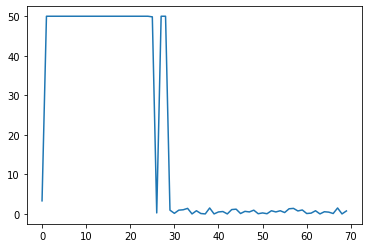

In [138]:
# -----------------
# This code is used to close an env that might not have been closed before
try:
  env.close()
except:
  pass
# -----------------

from mlagents_envs.registry import default_registry
from mlagents_envs.environment import UnityEnvironment
import matplotlib.pyplot as plt
%matplotlib inline

# Create the GridWorld Environment from the registry
env = UE(file_name='run31', seed=1, side_channels=[])
# env = default_registry["GridWorld"].make()
print("GridWorld environment created.")

# Create a new Q-Network. 
qnet = VisualQNetwork((44, 1), 126, 3)

experiences: Buffer = []
optim = torch.optim.Adam(qnet.parameters(), lr= 0.001)

cumulative_rewards: List[float] = []

# The number of training steps that will be performed
NUM_TRAINING_STEPS = 70
# The number of experiences to collect per training step
NUM_NEW_EXP = 1000
# The maximum size of the Buffer
BUFFER_SIZE = 10000

for n in range(NUM_TRAINING_STEPS):
  new_exp,_ = Trainer.generate_trajectories(env, qnet, NUM_NEW_EXP, epsilon=0.1)
  random.shuffle(experiences)
  if len(experiences) > BUFFER_SIZE:
    experiences = experiences[:BUFFER_SIZE]
  experiences.extend(new_exp)
  Trainer.update_q_net(qnet, optim, experiences, 3)
  _, rewards = Trainer.generate_trajectories(env, qnet, 100, epsilon=0)
  cumulative_rewards.append(rewards)
  print("Training step ", n+1, "\treward ", rewards)
  print()


env.close()

# Show the training graph
plt.plot(range(NUM_TRAINING_STEPS), cumulative_rewards)


In [13]:
env.close()
print("Closed environment")

Closed environment
